In [1]:
from transformers import (
    AutoTokenizer,
    BertTokenizerFast,
)
from custom.model import MammoCLIP
from custom.mammodata import MammogramDataset, MammogramPreprocessor, MammogramTransform
from custom.config import Config
import torch
import os
import pandas as pd
from torch.utils.data import DataLoader, WeightedRandomSampler
import matplotlib.pyplot as plt
import seaborn as sns
from richtqdm import RichTqdm
import numpy as np
from utils.freezer import freeze_submodules

In [2]:
project_dir = "./mammoclip-v1"
csv_path = "./data/essential-mammo.csv"

In [3]:
cfg = Config(
    project_dir="./mammoclip-v1/",
    seed=42,
    csv_path=csv_path,
    freeze_text_model=True,
    freeze_vision_model=True,
    ddp_kwargs=dict(find_unused_parameters=True),
    training_params=dict(
            num_epochs=30,
            train_fraction=0.8,
            batch_size=8,
            lr_max=5e-5,
            lr_min=5e-7,
            vision_lr_mul=1.0,
            text_lr_mul=1.0,
            fusion_lr_mul=5.0,
            lr_scheduler="wsd_schedule",
            warmup_fraction=0.05,
            steady_fraction=0.05,
            gradient_accumulation_steps=4,
            max_grad_norm=1.0,
            weight_decay=1e-1,
            eps=1e-8,
            betas=(0.9, 0.98),
            mixed_precision="bf16",
        ),
    dl_workers=dict(train=0, val=0),
    train_ds=dict(
            class_="MammogramDataset",
            attrs_=dict(
                path_to_df="./mammoclip-v1/train.csv",
                weights_col="weight",
                pid_col="id",
                image_cols=["r_cc", "l_cc", "r_mlo", "l_mlo"],
                text_col="report",
                alt_text_cols=["aug_report", "aug_report02"],
                image_preprocessor=dict(
                    class_="MammogramPreprocessor",
                    attrs_=dict(
                        output_size=(518, 518),
                        use_clahe=True,
                        extract_largest_cc=True,
                    ),
                ),
                transform_function=dict(
                    class_="MammogramTransform",
                    attrs_=dict(
                        size=(518, 518),
                        degrees=10,
                        translate=(0.05, 0.05),
                        scale=(0.9, 1.1),
                        shear=(10, 10),
                        brightness=0.1,
                        contrast=0.1,
                        gamma=(0.75, 1.25),
                        mean=(0.281,),
                        std=(0.217,),
                        noise_std=(0.0, 0.05),
                        prob=0.5,
                        dropout_prob=0.15,
                        is_validation=False,
                    ),
                ),
                tokenizer_kwargs=dict(
                    padding="max_length",
                    truncation=True,
                    max_length=256,
                    return_tensors="pt",
                ),
                alt_text_prob=0.66,
                cache_dir=".cache",
                tokenizer="microsoft/BiomedVLP-CXR-BERT-general",
            ),
        ),
    val_ds=dict(
            class_="MammogramDataset",
            attrs_=dict(
                path_to_df="./mammoclip-v1/val.csv",
                pid_col="id",
                image_cols=["r_cc", "l_cc", "r_mlo", "l_mlo"],
                text_col="report",
                weights_col="weight",
                image_preprocessor=dict(
                    class_="MammogramPreprocessor",
                    attrs_=dict(
                        output_size=(518, 518),
                        use_clahe=True,
                        extract_largest_cc=True,
                    ),
                ),
                transform_function=dict(
                    class_="MammogramTransform",
                    attrs_=dict(
                        size=(518, 518),
                        mean=(0.281,),
                        std=(0.217,),
                        is_validation=True,
                    ),
                ),
                tokenizer_kwargs=dict(
                    padding="max_length",
                    truncation=True,
                    max_length=256,
                    return_tensors="pt",
                ),
                alt_text_prob=0.0,
                cache_dir=".cache",
                tokenizer="microsoft/BiomedVLP-CXR-BERT-general",
            ),
        ),
    eval_interval=1,
    save_interval=1,
    max_checkpoints=5,
    pretrained_model_cfg=dict(
        vision_model_name_or_path="microsoft/rad-dino",
        text_model_name_or_path="microsoft/BiomedVLP-CXR-BERT-general",
        fusion_type="linear",
        num_views=4,
        verbose=False,
    ),
)

In [4]:
from utils.data_utils import prepare_dataloaders

train_dl, val_dl, *_ = prepare_dataloaders(cfg, False)

In [5]:
@torch.no_grad()
def find_mean_std(dataloader: DataLoader, num_samples: int = 100):
    mean_sum = 0
    std_sum = 0
    running_mean = []
    running_std = []
    n_samples = 0
    for sample in (pbar := RichTqdm(dataloader, total=num_samples//dataloader.batch_size)):
        batch_samples = sample.input_ids.shape[0]
        images = sample.pixel_values
        
        images = images.view(batch_samples, -1)
        
        mean_sum += images.mean(1).sum().item()
        std_sum += images.std(1).sum().item()
        n_samples += batch_samples
        
        running_mean.append(mean_sum / n_samples)  
        running_std.append(std_sum / n_samples)    
        
        pbar.set_description(desc=f"Mean: {running_mean[-1]:.4f}, Std: {running_std[-1]:.4f}")
        
        if n_samples >= num_samples:
            break
    return running_mean, running_std

In [6]:
def find_and_plot_meanstd(dl: DataLoader, num_samples: int = 400):
    rmean, rstd = find_mean_std(dl, num_samples)
    sns.lineplot(rmean, label="Running Mean")
    sns.lineplot(rstd, label="Running Std")
    plt.hlines(rmean[-1], 0, len(rmean), colors='r', linestyles='dashed', label=f"Final Mean: {rmean[-1]:.3f}", alpha=0.5)
    plt.hlines(rstd[-1], 0, len(rstd), colors='g', linestyles='dashed', label=f"Final Std: {rstd[-1]:.3f}", alpha=0.5)
    plt.legend()
    plt.grid()
    plt.title("Running Mean and Std")
    plt.xlabel("Batch Number")
    plt.ylabel("Value")
    plt.tight_layout()
    plt.show()

In [24]:
# load a sample
sample = next(iter(train_dl))

In [25]:
sample["pixel_values"].shape, sample["input_ids"].shape

(torch.Size([8, 4, 518, 518]), torch.Size([8, 256]))

In [26]:
sample["input_ids"][4]

tensor([    2,  2009,  1752, 10066,  3488,  3698,  1690,  2099, 25500,    16,
         6214,  1737,  3488,  4894,  9395,    46,    18,    43,  2878,  4098,
         2520,  2784,  6035,  1752,  2691,  1690,  1689,  2279, 10476,  3193,
           16, 12699,  5658,  8539,  1700,  7888,  3927,    16,  1988, 13220,
        13561,  1733,  8004,    18,  1689,  2279, 10476,  2784,  6035,  1752,
         6617,    43,  2113,    17, 24495,  9395,    24,    16,  4682, 13561,
         1733,  8004,    18,  1693,  4980,    17,  7783,  5151,  1752, 17702,
         1733,  1815, 12264,  2784,  6035,    18,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0, 

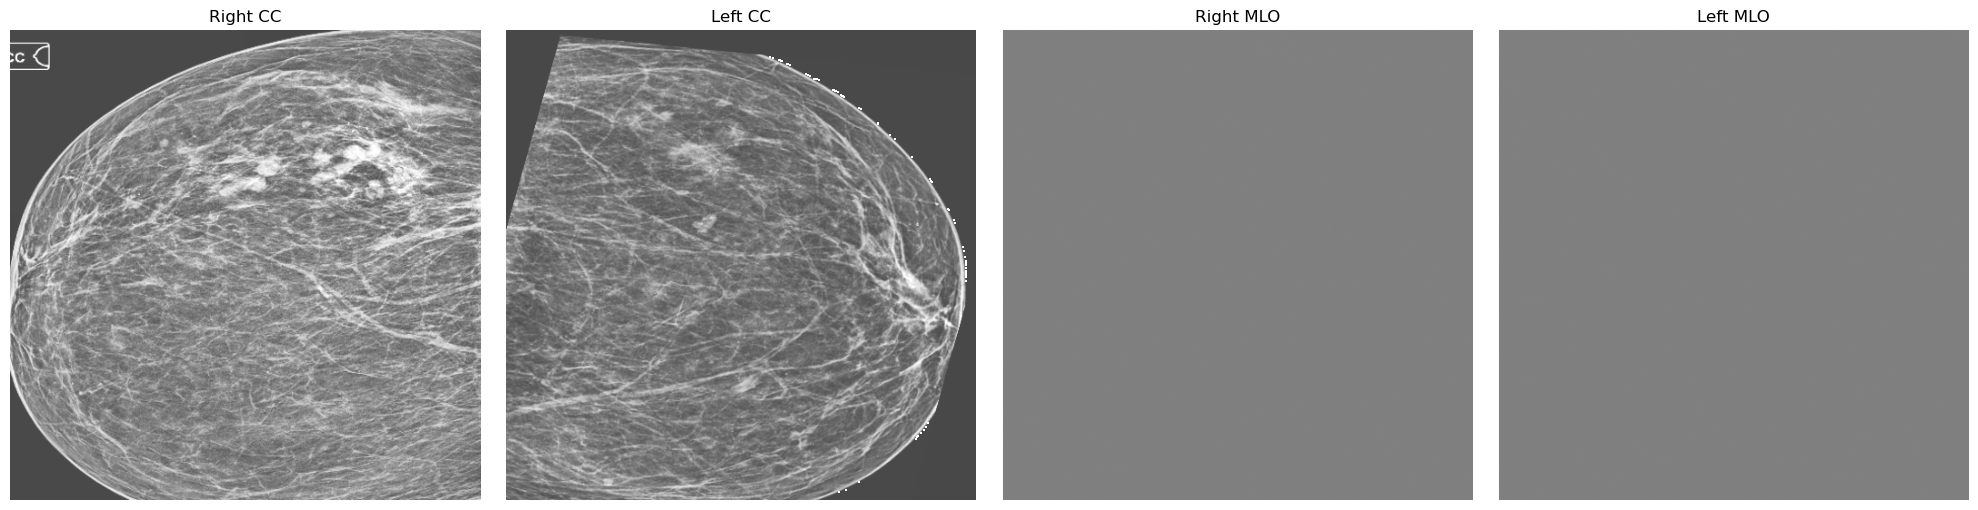

In [34]:
# show the image, each channel is a view
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    axs[i].imshow(sample.pixel_values[7][i], cmap="gray", vmin=-3, vmax=3)
    axs[i].axis("off")
axs[0].set_title("Right CC")
axs[1].set_title("Left CC")
axs[2].set_title("Right MLO")
axs[3].set_title("Left MLO")
plt.tight_layout()
plt.show()

In [2]:
model = MammoCLIP.from_vision_text_pretrained(
    "microsoft/rad-dino", "microsoft/BiomedVLP-CXR-BERT-general", num_views=4, verbose=True
)

The projection layer and logit scale weights `['visual_projection.weight', 'text_projection.weight', 'logit_scale']` are newly initialized. You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model initialized with 4 views.


In [3]:
for name, param in model.named_parameters():
    if name.startswith("fusion_"):
        print(name, param.shape)

fusion_layer.weight torch.Size([768, 3072])
fusion_embedding.view_embed.weight torch.Size([4, 768])


In [54]:
with torch.inference_mode():
    outputs = model(
        **sample,
        return_loss=True,
    )

Processing images with shape: torch.Size([8, 4, 518, 518]) (bs, c, h, w)
Stacked images shape: torch.Size([8, 4, 768]), Embedded images shape: torch.Size([8, 4, 768])
Fused embedding shape: torch.Size([8, 768])


In [58]:
loss, logits_per_image, logits_per_text = outputs.loss, outputs.logits_per_image, outputs.logits_per_text

In [59]:
print("Contrastive training loss:", loss.item())

Contrastive training loss: nan


In [60]:
print("Logits per image:\n", logits_per_image)

Logits per image:
 tensor([[-0.2992,  0.1906,  0.0837, -0.3934, -0.0935,  0.0715, -0.2714,  0.4720],
        [-0.9231,  0.3819, -0.6013, -0.9826, -0.6273, -0.5121, -0.6930, -0.1323],
        [-0.4967,  0.0790, -0.1537, -0.5949, -0.3056, -0.2102, -0.3884,  0.2874],
        [-0.1890, -0.0618,  0.2462, -0.3717,  0.0374,  0.1958, -0.3438,  0.4544],
        [    nan,     nan,     nan,     nan,     nan,     nan,     nan,     nan],
        [-0.5434,  0.3361, -0.2748, -0.7527, -0.4206, -0.3476, -0.5680, -0.1209],
        [-0.4959,  0.1509, -0.2655, -0.5161, -0.4168, -0.1810, -0.3156, -0.0340],
        [-0.6674,  0.5137, -0.3144, -0.7938, -0.4511, -0.1937, -0.6041, -0.0484]])


In [61]:
print("Logits per text:\n", logits_per_text)

Logits per text:
 tensor([[-0.2992, -0.9231, -0.4967, -0.1890,     nan, -0.5434, -0.4959, -0.6674],
        [ 0.1906,  0.3819,  0.0790, -0.0618,     nan,  0.3361,  0.1509,  0.5137],
        [ 0.0837, -0.6013, -0.1537,  0.2462,     nan, -0.2748, -0.2655, -0.3144],
        [-0.3934, -0.9826, -0.5949, -0.3717,     nan, -0.7527, -0.5161, -0.7938],
        [-0.0935, -0.6273, -0.3056,  0.0374,     nan, -0.4206, -0.4168, -0.4511],
        [ 0.0715, -0.5121, -0.2102,  0.1958,     nan, -0.3476, -0.1810, -0.1937],
        [-0.2714, -0.6930, -0.3884, -0.3438,     nan, -0.5680, -0.3156, -0.6041],
        [ 0.4720, -0.1323,  0.2874,  0.4544,     nan, -0.1209, -0.0340, -0.0484]])


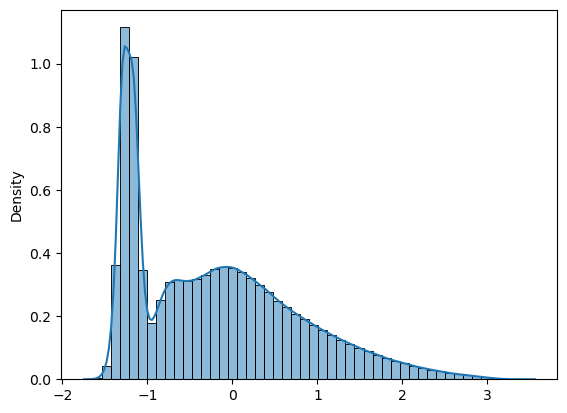

In [23]:
sns.histplot(sample.pixel_values.flatten(), bins=50, kde=True, stat="density")
plt.show()

In [24]:
# read the parameters to check
for name, param in model.named_parameters():
    if name == "vision_fused_attn.attention_net.0.weight":
        print(name, param.data)
        break

vision_fused_attn.attention_net.0.weight tensor([[-0.0221, -0.0294, -0.0260,  ...,  0.0360, -0.0063, -0.0298],
        [-0.0214,  0.0135,  0.0173,  ..., -0.0121,  0.0135,  0.0147],
        [-0.0305, -0.0323,  0.0331,  ..., -0.0123, -0.0120, -0.0050],
        ...,
        [ 0.0074, -0.0341, -0.0215,  ..., -0.0227,  0.0271, -0.0280],
        [ 0.0164, -0.0182,  0.0209,  ...,  0.0122, -0.0297,  0.0154],
        [-0.0209,  0.0117, -0.0048,  ..., -0.0127, -0.0226,  0.0150]])


In [25]:
model.save_pretrained("./mammoclip-model")

In [26]:
model = MammoCLIP.from_pretrained("./mammoclip-model")

You are using a model of type mammo_clip to instantiate a model of type vision-text-dual-encoder. This is not supported for all configurations of models and can yield errors.


In [27]:
# read the parameters to check
for name, param in model.named_parameters():
    if name == "vision_fused_attn.attention_net.0.weight":
        print(name, param.data)
        break

vision_fused_attn.attention_net.0.weight tensor([[-0.0221, -0.0294, -0.0260,  ...,  0.0360, -0.0063, -0.0298],
        [-0.0214,  0.0135,  0.0173,  ..., -0.0121,  0.0135,  0.0147],
        [-0.0305, -0.0323,  0.0331,  ..., -0.0123, -0.0120, -0.0050],
        ...,
        [ 0.0074, -0.0341, -0.0215,  ..., -0.0227,  0.0271, -0.0280],
        [ 0.0164, -0.0182,  0.0209,  ...,  0.0122, -0.0297,  0.0154],
        [-0.0209,  0.0117, -0.0048,  ..., -0.0127, -0.0226,  0.0150]])


In [28]:
print(f"number of parameters: {sum(p.numel() for p in model.parameters()):,}")

number of parameters: 197,147,906
